Stock-List Name? portfolio.txt
This may take up to 63s.

Requesting data for REGN...
Requesting data for EIX...
Requesting data for PCG...
Requesting data for ADBE...
Requesting data for PFE...


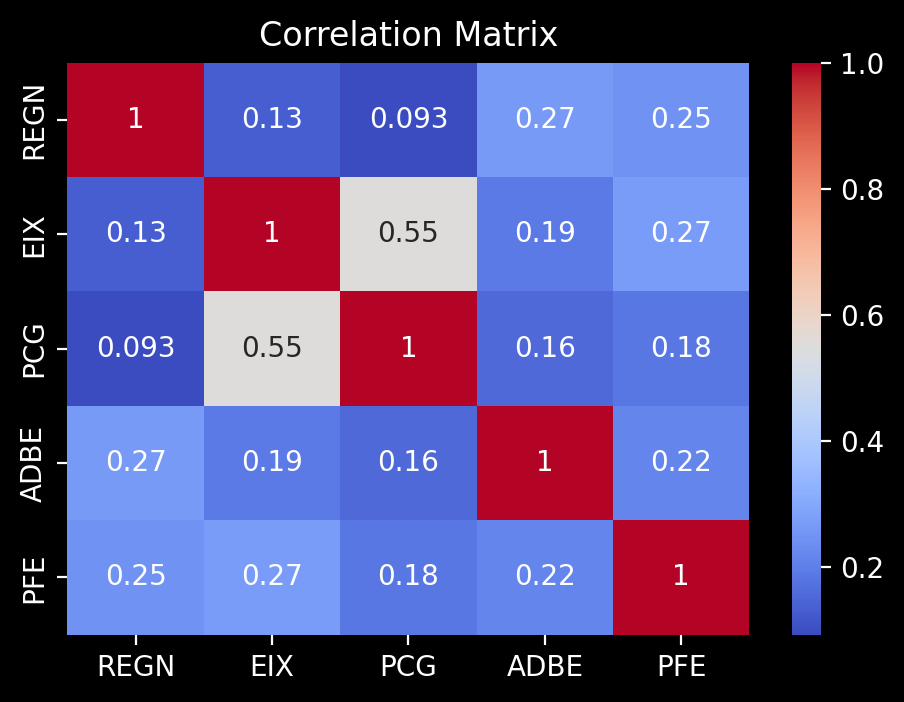

ATR smoothing length (e.g. 14)? 50


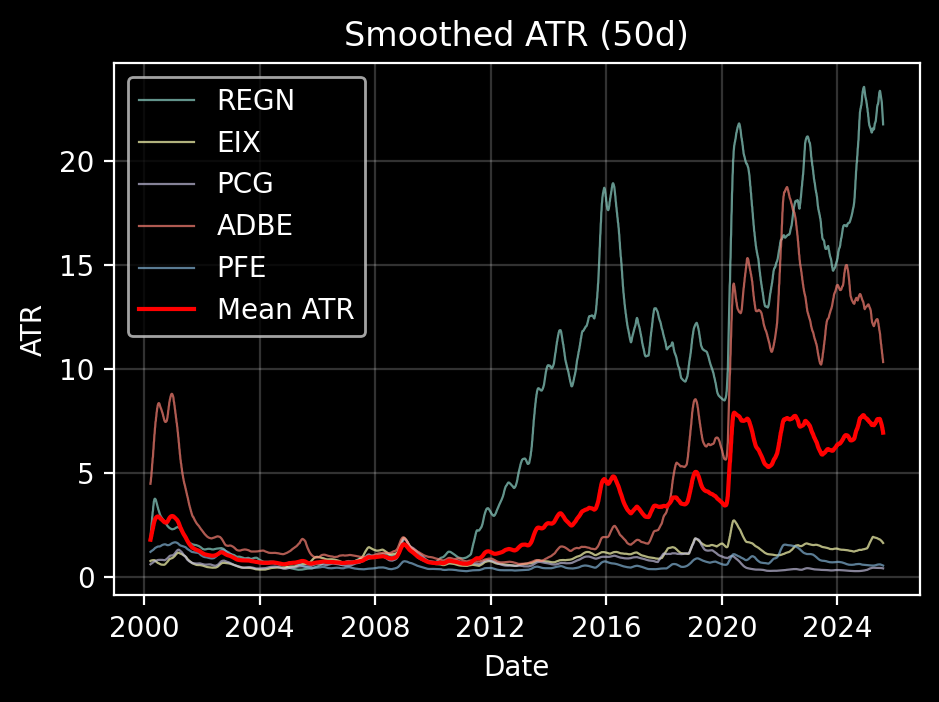

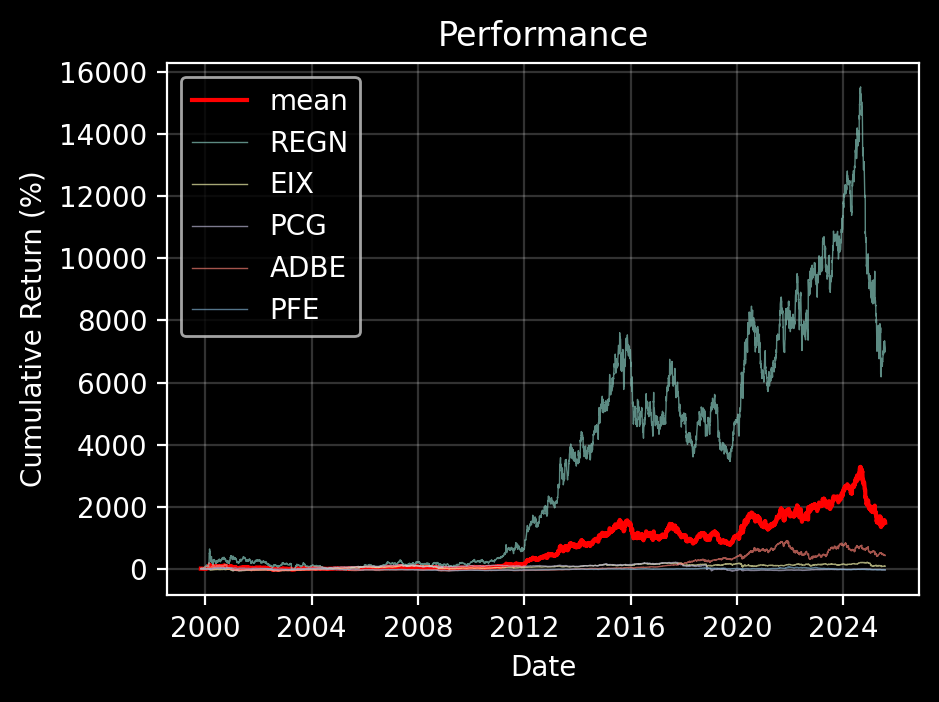

In [1]:
import requests
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import os


class portfolio_insider():
    def __init__(self, atr_length=50):
        
        with open('portfolio_insider_configs.json','r') as file:
            self.config_data = json.load(file)
            self.api_key = self.config_data['API-KEY'].strip()
        try:
            self.filename = input('Stock-List Name? ').strip()
        except FileNotFoundError:
            return
        
        self.returns_df = pd.DataFrame()
        self.atr_sma_df = pd.DataFrame()

        try:
            with open(self.filename, 'r') as file:
                self.stocks = [line.strip() for line in file.readlines()]
        except FileNotFoundError:
            print(f'❌ No such file as {self.filename}')
            print('Please create your portfolio with portfolio_manager.ipynb first.')
            return
        
        self.performance_df = pd.DataFrame(columns=[symbol for symbol in self.stocks])
                                           
        print(f'This may take up to {len(self.stocks) * 12 + 3}s.\n')

        for symbol in self.stocks:
            print(f"Requesting data for {symbol}...")
            url = (
                f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
                f'&symbol={symbol}&outputsize=full&apikey={self.api_key}'
            )

            response = requests.get(url)
            data = response.json()

            if "Note" in data:
                print(f"⚠️ API limit reached: {data['Note']}")
                return

            if "Time Series (Daily)" not in data:
                print(f"❌ Error at {symbol}: {data}")
                continue

            ts_data = data["Time Series (Daily)"]
            df = pd.DataFrame.from_dict(ts_data, orient='index')
            df.index = pd.to_datetime(df.index)
            df = df.rename(columns={
                '1. open': 'Open',
                '2. high': 'High',
                '3. low': 'Low',
                '4. close': 'Close'
            })

            try:
                df = df[['Open', 'High', 'Low', 'Close']].astype(float).sort_index()
            except Exception as e:
                print(f"⚠️ Error converting {symbol} data: {e}")
                continue
            
            returns = df['Close'].pct_change().dropna()
            
            cumulative = (1 + returns).cumprod() - 1
            scaled = cumulative - cumulative.iloc[0]
            
            self.performance_df[symbol] = scaled
            
            if self.returns_df.empty:
                self.returns_df = returns.to_frame(name=symbol)
            else:
                self.returns_df = self.returns_df.join(returns.to_frame(name=symbol), how='inner')

            atr = ta.atr(high=df['High'], low=df['Low'], close=df['Close'], length=atr_length)
            atr_sma = atr.rolling(window=atr_length).mean()

            self.atr_sma_df[symbol] = atr_sma

            time.sleep(12)

    def get_correlations(self):
        if self.returns_df.empty:
            print("❌ No return data available.")
            return

        corr = self.returns_df.corr()
        sns.heatmap(corr, cbar=True, cmap='coolwarm', annot=True)
        plt.title("Correlation Matrix")
        plt.tight_layout()
        plt.show()

    def get_atr(self):
        try:
            atr_length = int(input('ATR smoothing length (e.g. 14)? '))
            if atr_length < 1:
                raise ValueError
        except ValueError:
            print("Invalid input. Must be an integer >= 1.")
            return

        if self.atr_sma_df.empty:
            print("❌ No ATR data available.")
            return

        for symbol in self.atr_sma_df.columns:
            plt.plot(self.atr_sma_df[symbol], label=symbol, linewidth=0.8, alpha=0.7)

        mean_atr = self.atr_sma_df.mean(axis=1)
        plt.plot(mean_atr, label='Mean ATR', linewidth=1.5, color='red')

        plt.title(f'Smoothed ATR ({atr_length}d)')
        plt.xlabel('Date')
        plt.ylabel('ATR')
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()
        
    def get_performance(self):
        
        if self.performance_df.empty:
            print("❌ No return data available.")
            return
        
        plt.plot(self.performance_df.sum(axis=1)*100/len(self.stocks),linewidth=1.5,color='r',label='mean')
         
        for symbol in self.stocks:
            plt.plot(self.performance_df[symbol]*100,label=symbol,linewidth=0.5,alpha=0.66)
        
        plt.title('Performance')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()
        
                
client1 = portfolio_insider()
client1.get_correlations()
client1.get_atr()
client1.get_performance()